In [9]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)   

Populating the interactive namespace from numpy and matplotlib


In [29]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime


In [10]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
data=pd.read_csv('drive/My Drive/EURUSD60.csv')
data.head()

,Date,Time,Open,High,Low,Close,Volume
0,1999.01.04,10:00,1.1801,1.1819,1.1769,1.1789,388
1,1999.01.04,11:00,1.1795,1.1819,1.1780,1.1791,490
2,1999.01.04,12:00,1.1791,1.1803,1.1788,1.1798,278
3,1999.01.04,13:00,1.1797,1.1804,1.1781,1.1782,364
4,1999.01.04,14:00,1.1780,1.1820,1.1775,1.1802,482


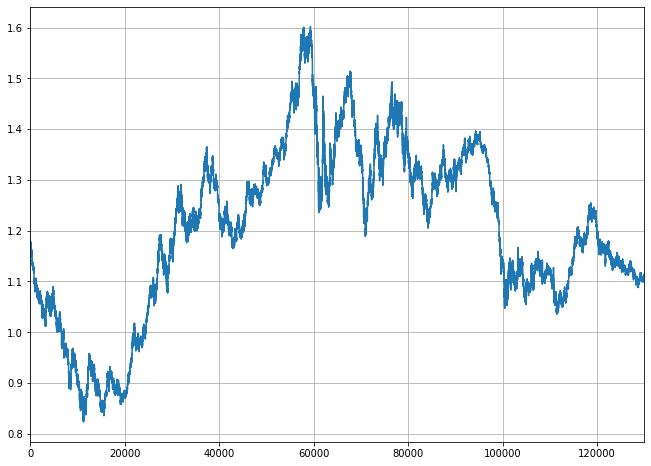

In [12]:

f, ax = plt.subplots(figsize=(11,8))

data['Close'].plot(grid = True)

In [0]:

# Fast moving window rolling mean
data['fast'] = data['Close'].rolling(window=2).mean()
# Short moving window rolling mean
data['slow'] = data['Close'].rolling(window=8).mean()

In [0]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


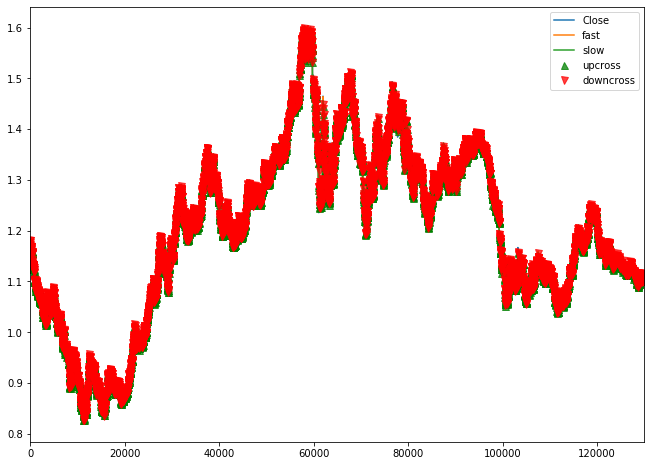

In [18]:
up = get_up_cross(data)
down = get_down_cross(data)

f, ax = plt.subplots(figsize=(11,8))

# Plot the adjusted closing price, the short and long windows of rolling means
data[['Close', 'fast', 'slow']].plot(ax=ax, grid=True)

up.plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [19]:
display(len(up.index), len(down.index))

10536

10537

In [20]:
# Creates a labebls
side_up = pd.Series(1, index=up.index).dropna()
side_down = pd.Series(-1, index=down.index).dropna()
side = pd.concat([side_up,side_down]).sort_index()
display(side[:5], side.shape)

14   -1
20    1
25   -1
34    1
35   -1
dtype: int64

(21073,)

In [21]:
crossEvents = side.index
crossEvents.values

array([    14,     20,     25, ..., 129921, 129928, 129929])

In [22]:
adj_close = data['Close']
adj_close[:5]

0    1.1789
1    1.1791
2    1.1798
3    1.1782
4    1.1802
Name: Close, dtype: float64

In [0]:
def metaLabling(close, startEvents, side, verticalBarrier , SL = 0.010, TP = 0.015):
    
    
    """
    Meta Labling Funcion:
    ====================
    params : 
        - close : numpy_array
        - start events : numpy_array (Cross evet)
        - side : numpy_array
        - verticalBarrier:
        - Stop Loss : SL 
        - Take Profit : TP

    returns :
        - first touched level 
        - row return 
        - percent return 
        - side of the position
    """
    
    if verticalBarrier is None:
        verticalBarrier = pd.Series(close.index[-1], index=startEvents)


    ret = pd.DataFrame(columns=['touch_tp', 'raw_return', 'p_return', 'side'], index=startEvents)
    t_touch = 0
    r_ret = 0
    p_ret = 0
    
    for t0 in tqdm(startEvents):
   # for t0 in startEvents:
        window = close[t0:verticalBarrier[t0]]
        
        if(side[t0] == 1):
            trgHi = close[t0] * TP  # 1.5% * Close 200 * .015 =>  3 $ 
            trgLow = close[t0] * SL # 1% * Close 200*.01  => 2 $
        else:
            trgHi = close[t0] * SL # 1% * Close
            trgLow = close[t0] * TP # 1.5% * Close
        
        fabove = window >= (trgHi+close[t0]) # Higher Than Highest : [True,False,False,True,...] 203$ ?
        fbelow = window <= (close[t0]-trgLow)# Lower Than Lowest : [True,False,False,True,...] 198 ?
        
        hiTouch = window[fabove].index.min()
        lowTouch = window[fbelow].index.min()
        
        #print('ht',(hiTouch))
        #print('lt',(lowTouch))
        
        if ((pd.isnull(hiTouch)) and (pd.isnull(lowTouch))):
            #display('vertical barrier or infinit')
            t_touch = 0
            r_ret = close[verticalBarrier[t0]]
            
        elif (pd.isnull(hiTouch) and (not pd.isnull(lowTouch))):
            #display('low touch')
            t_touch = -1 
            r_ret = close[lowTouch]
        elif (not pd.isnull(hiTouch) and (pd.isnull(lowTouch))):
            #display('hi touch')
            t_touch = 1 
            r_ret = close[hiTouch]
        elif(hiTouch < lowTouch):
            #display('HI')
            t_touch = 1
            r_ret = close[hiTouch]
        else:
           # display('LOW')
            t_touch = -1
            r_ret = close[lowTouch]

            
        ret.loc[t0].touch_tp = t_touch * side[t0]
        ret.loc[t0].raw_return = abs(r_ret - close[t0]) * ret.loc[t0].touch_tp
        ret.loc[t0].p_return = abs(r_ret / close[t0] - 1 ) * ret.loc[t0].touch_tp
        ret.loc[t0].side = side[t0]

        
    return ret

In [24]:
df_met = metaLabling(adj_close, crossEvents, side, None, 0.10, 0.25)
df_met.head(10)

100%|██████████| 21073/21073 [01:12<00:00, 291.90it/s]


,touch_tp,raw_return,p_return,side
14,1,0.2955,0.250042,-1
20,-1,-0.119,-0.100711,1
25,1,0.296,0.250762,-1
34,-1,-0.118,-0.100212,1
35,1,0.2941,0.250085,-1
43,-1,-0.1176,-0.100153,1
50,1,0.295,0.251513,-1
60,-1,-0.1173,-0.100895,1
71,1,0.2959,0.253687,-1
72,-1,-0.1188,-0.101591,1


In [25]:
n_data = pd.merge(data, df_met, left_index=True, right_index=True)
n_data.shape

(21073, 13)

In [26]:
display("before:", n_data.touch_tp.value_counts())
f = n_data.raw_return < 0.10
n_data.loc[f,'touch_tp'] = 0
f = n_data.touch_tp == -1
n_data.loc[f,'touch_tp'] = 0
n_data[f].head()
display("after:", n_data.touch_tp.value_counts())

'before:'

-1    11825
 0     5079
 1     4169
Name: touch_tp, dtype: int64

'after:'

0    16904
1     4169
Name: touch_tp, dtype: int64

In [28]:
X = n_data[['Volume', 'Close', 'fast', 'slow', 'side']]
y = n_data.touch_tp
X.shape

(21073, 5)

In [0]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xs, np.array(y), test_size=0.10, random_state=42, shuffle=False)

In [31]:
  Xs

array([[-0.76713207, -0.11475359, -0.11568578, -0.11280228, -0.99995255],
       [-0.66403879, -0.11595213, -0.11748359, -0.1178958 ,  1.00004746],
       [-0.62684435, -0.12314336, -0.11838249, -0.11669733, -0.99995255],
       ...,
       [-0.49545094, -0.52333544, -0.52229037, -0.52146014, -0.99995255],
       [ 1.34931248, -0.52201705, -0.52402826, -0.52502561,  1.00004746],
       [ 1.62948364, -0.53016711, -0.5261257 , -0.52587952, -0.99995255]])

In [36]:
from keras.models import Sequential
from keras.layers import Dense

model=Sequential()
model.add(Dense(5, activation='relu',input_shape=(5,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=100 , validation_split=0.1, shuffle=False , verbose=2)




Train on 17068 samples, validate on 1897 samples
Epoch 1/100





 - 1s - loss: 0.4509 - acc: 0.8459 - val_loss: 0.0621 - val_acc: 1.0000
Epoch 2/100
 - 1s - loss: 0.2688 - acc: 0.9146 - val_loss: 0.0675 - val_acc: 0.9815
Epoch 3/100
 - 1s - loss: 0.2574 - acc: 0.9017 - val_loss: 0.1050 - val_acc: 0.9489
Epoch 4/100
 - 1s - loss: 0.2741 - acc: 0.8938 - val_loss: 0.1168 - val_acc: 0.9431
Epoch 5/100
 - 1s - loss: 0.2838 - acc: 0.8852 - val_loss: 0.1202 - val_acc: 0.9404
Epoch 6/100
 - 1s - loss: 0.2921 - acc: 0.8762 - val_loss: 0.1103 - val_acc: 0.9431
Epoch 7/100
 - 1s - loss: 0.2668 - acc: 0.8996 - val_loss: 0.1066 - val_acc: 0.9410
Epoch 8/100
 - 1s - loss: 0.2557 - acc: 0.9019 - val_loss: 0.1097 - val_acc: 0.9373
Epoch 9/100
 - 1s - loss: 0.2527 - acc: 0.9030 - val_loss: 0.1066 - val_acc: 0.9378
Epoch 10/100
 - 1s - loss: 0.2456 - acc: 0.9038 - val_loss: 0.1060 - val_acc: 0.9378
Epoch 11/100
 - 1s - loss: 0.2415 - acc: 0.9039 - val_loss: 0.1051 - val_acc: 0.9378
Epoch 12/100
 - 1

In [38]:
model.evaluate(X_test, y_test)


2108/2108 [==============================] - 0s 22us/step


[0.1410746844697468, 0.9392789373814042]